# Lab: Logistic Regression and KNN


## The Stock Market Data

In this lab we will examine the `Smarket` 
data, which is part of the `ISLP`
library. This data set consists of percentage returns for the S&P 500
stock index over 1,250 days, from the beginning of 2001 until the end
of 2005. For each date, we have recorded the percentage returns for
each of the five previous trading days,  `Lag1`  through
 `Lag5`. We have also recorded  `Volume`  (the number of
shares traded on the previous day, in billions),  `Today`  (the
percentage return on the date in question) and  `Direction`
(whether the market was  `Up`  or  `Down`  on this date).

We start by importing  our libraries at this top level; these are all imports we have seen in previous labs.

In [1]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (ModelSpec as MS,
                         summarize)

We also collect together the new imports needed for this lab.

In [2]:
from ISLP import confusion_table
from ISLP.models import contrast
from sklearn.discriminant_analysis import \
     (LinearDiscriminantAnalysis as LDA,
      QuadraticDiscriminantAnalysis as QDA)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


Now we are ready to load the `Smarket` data.

In [3]:
Smarket = load_data('Smarket')
Smarket

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,2001,0.381,-0.192,-2.624,-1.055,5.010,1.19130,0.959,Up
1,2001,0.959,0.381,-0.192,-2.624,-1.055,1.29650,1.032,Up
2,2001,1.032,0.959,0.381,-0.192,-2.624,1.41120,-0.623,Down
3,2001,-0.623,1.032,0.959,0.381,-0.192,1.27600,0.614,Up
4,2001,0.614,-0.623,1.032,0.959,0.381,1.20570,0.213,Up
...,...,...,...,...,...,...,...,...,...
1245,2005,0.422,0.252,-0.024,-0.584,-0.285,1.88850,0.043,Up
1246,2005,0.043,0.422,0.252,-0.024,-0.584,1.28581,-0.955,Down
1247,2005,-0.955,0.043,0.422,0.252,-0.024,1.54047,0.130,Up
1248,2005,0.130,-0.955,0.043,0.422,0.252,1.42236,-0.298,Down


This gives a truncated listing of the data.
We can see what the variable names are.

In [4]:
Smarket.columns

Index(['Year', 'Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume', 'Today',
       'Direction'],
      dtype='object')

We compute the correlation matrix using the `corr()` method
for data frames, which produces a matrix that contains all of
the pairwise correlations among the variables.
 
By instructing `pandas` to use only numeric variables, the `corr()` method does not report a correlation for the `Direction`  variable because it is
 qualitative.
 
 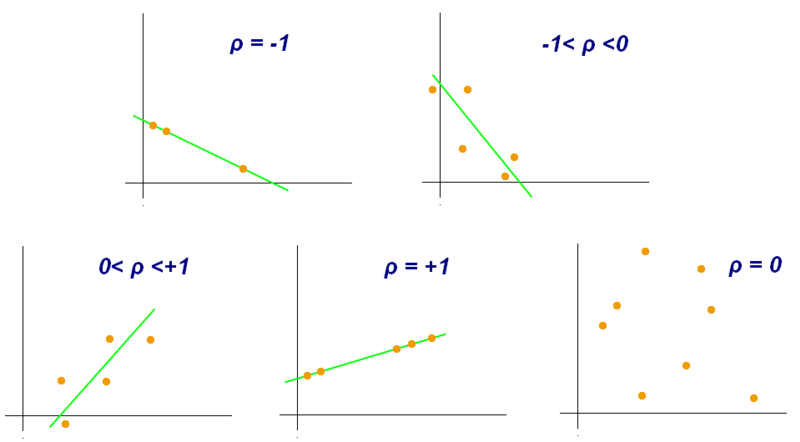

In [5]:
Smarket.corr(numeric_only=True)


,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
Year,1.000000,0.029700,0.030596,0.033195,0.035689,0.029788,0.539006,0.030095
Lag1,0.029700,1.000000,-0.026294,-0.010803,-0.002986,-0.005675,0.040910,-0.026155
Lag2,0.030596,-0.026294,1.000000,-0.025897,-0.010854,-0.003558,-0.043383,-0.010250
Lag3,0.033195,-0.010803,-0.025897,1.000000,-0.024051,-0.018808,-0.041824,-0.002448
Lag4,0.035689,-0.002986,-0.010854,-0.024051,1.000000,-0.027084,-0.048414,-0.006900
Lag5,0.029788,-0.005675,-0.003558,-0.018808,-0.027084,1.000000,-0.022002,-0.034860
Volume,0.539006,0.040910,-0.043383,-0.041824,-0.048414,-0.022002,1.000000,0.014592
Today,0.030095,-0.026155,-0.010250,-0.002448,-0.006900,-0.034860,0.014592,1.000000


As one would expect, the correlations between the lagged return  variables and
today’s return are close to zero.  The only substantial correlation is between  `Year`  and
 `Volume`. By plotting the data we see that  `Volume`
is increasing over time. In other words, the average number of shares traded
daily increased from 2001 to 2005.


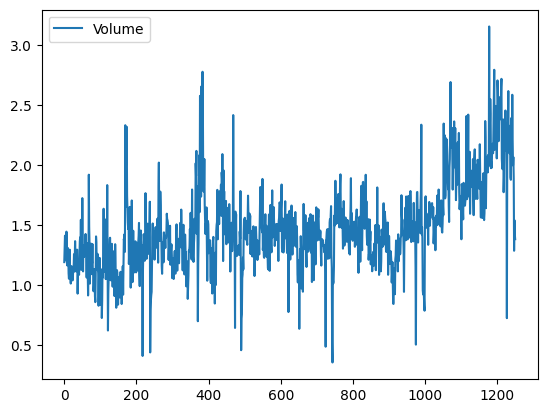

In [6]:
Smarket.plot(y='Volume');


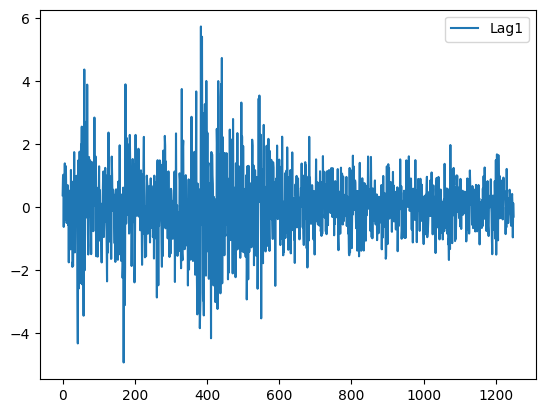

In [7]:
Smarket.plot(y='Lag1');

## Logistic Regression
Next, we will fit a logistic regression model in order to predict
 `Direction`  using  `Lag1`  through  `Lag5`  and
 `Volume`. The `sm.GLM()`  function fits *generalized linear models*, a class of
models that includes logistic regression.  Alternatively,
the function `sm.Logit()` fits a logistic regression
model directly. The syntax of
`sm.GLM()` is similar to that of `sm.OLS()`, except
that we must pass in the argument `family=sm.families.Binomial()`
in order to tell `statsmodels` to run a logistic regression rather than some other
type of generalized linear model.

In [8]:
allvars = Smarket.columns.drop(['Today', 'Direction', 'Year'])
design = MS(allvars)
X = design.fit_transform(Smarket)
y = Smarket.Direction == 'Up'
glm = sm.GLM(y,
             X,
             family=sm.families.Binomial())
results = glm.fit()
summarize(results)


,coef,std err,z,P>|z|
intercept,-0.1260,0.241,-0.523,0.601
Lag1,-0.0731,0.050,-1.457,0.145
Lag2,-0.0423,0.050,-0.845,0.398
Lag3,0.0111,0.050,0.222,0.824
Lag4,0.0094,0.050,0.187,0.851
Lag5,0.0103,0.050,0.208,0.835
Volume,0.1354,0.158,0.855,0.392


The smallest *p*-value here is associated with  `Lag1`. The
negative coefficient for this predictor suggests that if the market
had a positive return yesterday, then it is less likely to go up
today. However, at a value of 0.15, the *p*-value is still
relatively large, and so there is no clear evidence of a real
association between  `Lag1`  and  `Direction`.

We use the `params`  attribute of `results`
in order to access just the
coefficients for this fitted model.

In [9]:
results.params


intercept   -0.126000
Lag1        -0.073074
Lag2        -0.042301
Lag3         0.011085
Lag4         0.009359
Lag5         0.010313
Volume       0.135441
dtype: float64

Likewise we can use the
`pvalues`  attribute to access the *p*-values for the coefficients.

In [10]:
results.pvalues


intercept    0.600700
Lag1         0.145232
Lag2         0.398352
Lag3         0.824334
Lag4         0.851445
Lag5         0.834998
Volume       0.392404
dtype: float64

The `predict()`  method of `results` can be used to predict the
probability that the market will go up, given values of the
predictors. This method returns predictions
on the probability scale. If no data set is supplied to the `predict()`
function, then the probabilities are computed for the training data
that was used to fit the logistic regression model.
As with linear regression, one can pass an optional `exog` argument consistent
with a design matrix if desired. Here we have
printed only the first ten probabilities.

In [9]:
probs = results.predict()
probs[:10]


array([0.50708413, 0.48146788, 0.48113883, 0.51522236, 0.51078116,
       0.50695646, 0.49265087, 0.50922916, 0.51761353, 0.48883778])

In order to make a prediction as to whether the market will go up or
down on a particular day, we must convert these predicted
probabilities into class labels,  `Up`  or  `Down`.  The
following two commands create a vector of class predictions based on
whether the predicted probability of a market increase is greater than
or less than 0.5.

In [10]:
labels = np.array(['Down']*1250)
labels[probs>0.5] = "Up"


The `confusion_table()`
function from the `ISLP` package summarizes these predictions, showing   how
many observations were correctly or incorrectly classified. Our function, which is adapted from a similar function
in the module `sklearn.metrics`,  transposes the resulting
matrix and includes row and column labels.
The `confusion_table()` function takes as first argument the
predicted labels, and second argument the true labels.

In [11]:
confusion_table(labels, Smarket.Direction)


Truth,Down,Up
Predicted,,
Down,145,141
Up,457,507


The diagonal elements of the confusion matrix indicate correct
predictions, while the off-diagonals represent incorrect
predictions. Hence our model correctly predicted that the market would
go up on 507 days and that it would go down on 145 days, for a
total of 507 + 145 = 652 correct predictions. The `np.mean()`
function can be used to compute the fraction of days for which the
prediction was correct. In this case, logistic regression correctly
predicted the movement of the market 52.2% of the time.


In [12]:
(507+145)/1250, np.mean(labels == Smarket.Direction)


(0.5216, 0.5216)

At first glance, it appears that the logistic regression model is
working a little better than random guessing. However, this result is
misleading because we trained and tested the model on the same set of
1,250 observations. In other words, $100-52.2=47.8%$ is the
*training* error  rate. As we have seen
previously, the training error rate is often overly optimistic --- it
tends to underestimate the test error rate.  In
order to better assess the accuracy of the logistic regression model
in this setting, we can fit the model using part of the data, and
then examine how well it predicts the *held out* data.  This
will yield a more realistic error rate, in the sense that in practice
we will be interested in our model’s performance not on the data that
we used to fit the model, but rather on days in the future for which
the market’s movements are unknown.

To implement this strategy, we first create a Boolean vector
corresponding to the observations from 2001 through 2004. We  then
use this vector to create a held out data set of observations from
2005.

In [13]:
train = (Smarket.Year < 2005)
Smarket_train = Smarket.loc[train]
Smarket_test = Smarket.loc[~train]
Smarket_test.shape


(252, 9)

The object `train` is a vector of 1,250 elements, corresponding
to the observations in our data set. The elements of the vector that
correspond to observations that occurred before 2005 are set to
`True`, whereas those that correspond to observations in 2005 are
set to `False`.  Hence `train` is a
*boolean*   array, since its
elements are `True` and `False`.  Boolean arrays can be used
to obtain a subset of the rows or columns of a data frame
using the `loc` method. For instance,
the command `Smarket.loc[train]` would pick out a submatrix of the
stock market data set, corresponding only to the dates before 2005,
since those are the ones for which the elements of `train` are
`True`.  The `~` symbol can be used to negate all of the
elements of a Boolean vector. That is, `~train` is a vector
similar to `train`, except that the elements that are `True`
in `train` get swapped to `False` in `~train`, and vice versa.
Therefore, `Smarket.loc[~train]` yields a
subset of the rows of the data frame
of the stock market data containing only the observations for which
`train` is `False`.
The output above indicates that there are 252 such
observations.

We now fit a logistic regression model using only the subset of the
observations that correspond to dates before 2005. We then obtain predicted probabilities of the
stock market going up for each of the days in our test set --- that is,
for the days in 2005.

In [14]:
X_train, X_test = X.loc[train], X.loc[~train]
y_train, y_test = y.loc[train], y.loc[~train]
glm_train = sm.GLM(y_train,
                   X_train,
                   family=sm.families.Binomial())
results = glm_train.fit()
probs = results.predict(exog=X_test)


Notice that we have trained and tested our model on two completely
separate data sets: training was performed using only the dates before
2005, and testing was performed using only the dates in 2005.

Finally, we compare the predictions for 2005 to the
actual movements of the market over that time period.
We will first store the test and training labels (recall `y_test` is binary).

In [15]:
D = Smarket.Direction
L_train, L_test = D.loc[train], D.loc[~train]


Now we threshold the
fitted probability at 50% to form
our predicted labels.

In [16]:
labels = np.array(['Down']*252)
labels[probs>0.5] = 'Up'
confusion_table(labels, L_test)


Truth,Down,Up
Predicted,,
Down,77,97
Up,34,44


The test accuracy is about 48% while the error rate is about 52%

In [17]:
np.mean(labels == L_test), np.mean(labels != L_test)


(0.4801587301587302, 0.5198412698412699)

The `!=` notation means *not equal to*, and so the last command
computes the test set error rate. The results are rather
disappointing: the test error rate is 52%, which is worse than
random guessing! Of course this result is not all that surprising,
given that one would not generally expect to be able to use previous
days’ returns to predict future market performance. (After all, if it
were possible to do so, then the authors of this book would be out
striking it rich rather than writing a statistics textbook.)

We recall that the logistic regression model had very underwhelming
*p*-values associated with all of the predictors, and that the
smallest *p*-value, though not very small, corresponded to
 `Lag1`. Perhaps by removing the variables that appear not to be
helpful in predicting  `Direction`, we can obtain a more
effective model. After all, using predictors that have no relationship
with the response tends to cause a deterioration in the test error
rate (since such predictors cause an increase in variance without a
corresponding decrease in bias), and so removing such predictors may
in turn yield an improvement.  Below we refit the logistic
regression using just  `Lag1`  and  `Lag2`, which seemed to
have the highest predictive power in the original logistic regression
model.

In [18]:
model = MS(['Lag1', 'Lag2']).fit(Smarket)
X = model.transform(Smarket)
X_train, X_test = X.loc[train], X.loc[~train]
glm_train = sm.GLM(y_train,
                   X_train,
                   family=sm.families.Binomial())
results = glm_train.fit()
probs = results.predict(exog=X_test)
labels = np.array(['Down']*252)
labels[probs>0.5] = 'Up'
confusion_table(labels, L_test)


Truth,Down,Up
Predicted,,
Down,35,35
Up,76,106


Let’s evaluate the overall accuracy as well as the accuracy within the days when
logistic regression predicts an increase.

In [19]:
(35+106)/252,106/(106+76)


(0.5595238095238095, 0.5824175824175825)

Now the results appear to be a little better: 56% of the daily
movements have been correctly predicted. It is worth noting that in
this case, a much simpler strategy of predicting that the market will
increase every day will also be correct 56% of the time! Hence, in
terms of overall error rate, the logistic regression method is no
better than the naive approach. However, the confusion matrix
shows that on days when logistic regression predicts an increase in
the market, it has a 58% accuracy rate. This suggests a possible
trading strategy of buying on days when the model predicts an
increasing market, and avoiding trades on days when a decrease is
predicted. Of course one would need to investigate more carefully
whether this small improvement was real or just due to random chance.

Suppose that we want to predict the returns associated with particular
values of  `Lag1`  and  `Lag2`. In particular, we want to
predict  `Direction`  on a day when  `Lag1`  and
 `Lag2`  equal $1.2$ and $1.1$, respectively, and on a day when they
equal $1.5$ and $-0.8$.  We do this using the `predict()`
function.

In [20]:
newdata = pd.DataFrame({'Lag1':[1.2, 1.5],
                        'Lag2':[1.1, -0.8]});
newX = model.transform(newdata)
results.predict(newX)


0    0.479146
1    0.496094
dtype: float64

In [21]:
Smarket

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,2001,0.381,-0.192,-2.624,-1.055,5.010,1.19130,0.959,Up
1,2001,0.959,0.381,-0.192,-2.624,-1.055,1.29650,1.032,Up
2,2001,1.032,0.959,0.381,-0.192,-2.624,1.41120,-0.623,Down
3,2001,-0.623,1.032,0.959,0.381,-0.192,1.27600,0.614,Up
4,2001,0.614,-0.623,1.032,0.959,0.381,1.20570,0.213,Up
...,...,...,...,...,...,...,...,...,...
1245,2005,0.422,0.252,-0.024,-0.584,-0.285,1.88850,0.043,Up
1246,2005,0.043,0.422,0.252,-0.024,-0.584,1.28581,-0.955,Down
1247,2005,-0.955,0.043,0.422,0.252,-0.024,1.54047,0.130,Up
1248,2005,0.130,-0.955,0.043,0.422,0.252,1.42236,-0.298,Down


   Year   Lag1   Lag2   Lag3   Lag4   Lag5  Volume  Today Direction
0  2001  0.381 -0.192 -2.624 -1.055  5.010  1.1913  0.959        Up
1  2001  0.959  0.381 -0.192 -2.624 -1.055  1.2965  1.032        Up
2  2001  1.032  0.959  0.381 -0.192 -2.624  1.4112 -0.623      Down
3  2001 -0.623  1.032  0.959  0.381 -0.192  1.2760  0.614        Up
4  2001  0.614 -0.623  1.032  0.959  0.381  1.2057  0.213        Up
              precision    recall  f1-score   support

           0       0.57      0.16      0.25       191
           1       0.50      0.88      0.64       184

    accuracy                           0.51       375
   macro avg       0.54      0.52      0.45       375
weighted avg       0.54      0.51      0.44       375

[[ 31 160]
 [ 23 161]]


/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinsta

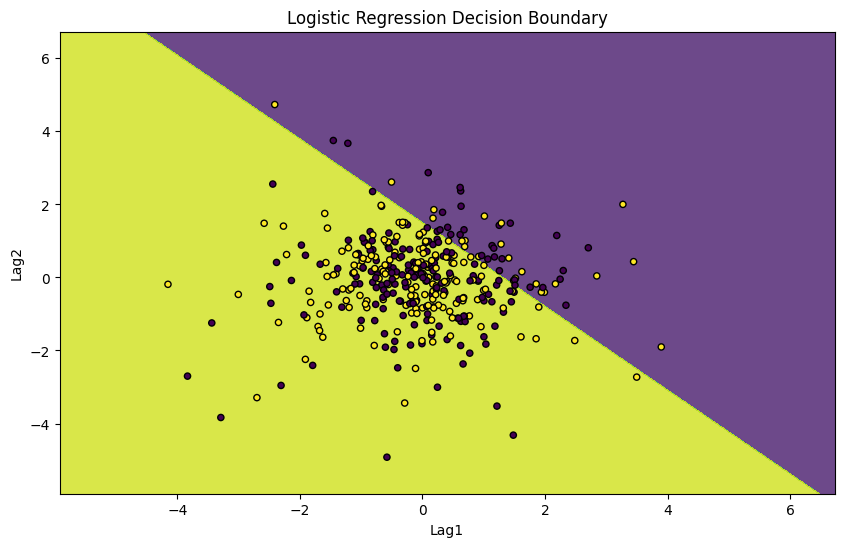

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import statsmodels.api as sm


# Load the dataset
data = load_data('Smarket')

# Display the first few rows of the dataset
print(data.head())

# Prepare the data for logistic regression
# Using 'Lag1' and 'Lag2' as predictors and 'Direction' as the response
data['Direction'] = data['Direction'].map({'Up': 1, 'Down': 0})
X = data[['Lag1', 'Lag2']]
y = data['Direction']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit the logistic regression model
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

# Make predictions on the test set
y_pred = log_reg.predict(X_test)

# Print classification report and confusion matrix
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# Visualize the decision boundary
plt.figure(figsize=(10, 6))

# Create a mesh grid for plotting decision boundary
x_min, x_max = X['Lag1'].min() - 1, X['Lag1'].max() + 1
y_min, y_max = X['Lag2'].min() - 1, X['Lag2'].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

# Predict the function value for the whole grid
Z = log_reg.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundary
plt.contourf(xx, yy, Z, alpha=0.8)
plt.scatter(X_test['Lag1'], X_test['Lag2'], c=y_test, edgecolor='k', s=20)
plt.xlabel('Lag1')
plt.ylabel('Lag2')
plt.title('Logistic Regression Decision Boundary')
plt.show()

## Naive Bayes
Next, we fit a naive Bayes model to the `Smarket` data. The syntax is
similar to that of `LDA()` and `QDA()`. By
default, this implementation `GaussianNB()` of the naive Bayes classifier models each
quantitative feature using a Gaussian distribution. However, a kernel
density method can also be used to estimate the distributions.

In [ ]:
NB = GaussianNB()
NB.fit(X_train, L_train)


The classes are stored as `classes_`.

In [ ]:
NB.classes_


The class prior probabilities are stored in the `class_prior_` attribute.

In [ ]:
NB.class_prior_


The parameters of the features can be found in the `theta_` and `var_` attributes. The number of rows
is equal to the number of classes, while the number of columns is equal to the number of features.
We see below that the mean for feature `Lag1` in the `Down` class is 0.043.

In [ ]:
NB.theta_


Its variance is 1.503.

In [ ]:
NB.var_


How do we know the names of these attributes? We use `NB?` (or `?NB`).

We can easily verify the mean computation:

In [ ]:
X_train[L_train == 'Down'].mean()


Similarly for the variance:

In [ ]:
X_train[L_train == 'Down'].var(ddof=0)


Since `NB()` is a classifier in the `sklearn` library, making predictions
uses the same syntax as for `LDA()` and `QDA()` above.

In [ ]:
nb_labels = NB.predict(X_test)
confusion_table(nb_labels, L_test)


Naive Bayes performs well on these data, with accurate predictions over 59% of the time. This is slightly worse than QDA, but much better than LDA.

As for `LDA`, the `predict_proba()` method estimates the probability that each observation belongs to a particular class.

In [ ]:
NB.predict_proba(X_test)[:5]


## K-Nearest Neighbors
We will now perform KNN using the `KNeighborsClassifier()` function. This function works similarly
to the other model-fitting functions that we have
encountered thus far.

As is the
case for LDA and QDA, we fit the classifier
using the `fit` method. New
predictions are formed using the `predict` method
of the object returned by `fit()`.

In [ ]:
knn1 = KNeighborsClassifier(n_neighbors=1)
X_train, X_test = [np.asarray(X) for X in [X_train, X_test]]
knn1.fit(X_train, L_train)
knn1_pred = knn1.predict(X_test)
confusion_table(knn1_pred, L_test)


The results using $K=1$ are not very good, since only $50%$ of the
observations are correctly predicted. Of course, it may be that $K=1$
results in an overly-flexible fit to the data.

In [ ]:
(83+43)/252, np.mean(knn1_pred == L_test)


We repeat the
analysis below using $K=3$.

In [ ]:
knn3 = KNeighborsClassifier(n_neighbors=3)
knn3_pred = knn3.fit(X_train, L_train).predict(X_test)
np.mean(knn3_pred == L_test)

The results have improved slightly. But increasing *K* further
provides no further improvements. It appears that for these data, and this train/test split,
QDA gives the best results of the methods that we have examined so
far.

KNN does not perform well on the `Smarket`  data, but it often does provide impressive results. As an example we will apply the KNN approach to the `Caravan`  data set, which is part of the `ISLP` library.  This data set includes 85
predictors that measure demographic characteristics for 5,822
individuals. The response variable is  `Purchase`, which
indicates whether or not a given individual purchases a caravan
insurance policy. In this data set, only 6% of people purchased
caravan insurance.

In [ ]:
Caravan = load_data('Caravan')
Purchase = Caravan.Purchase
Purchase.value_counts()


The method `value_counts()` takes a `pd.Series` or `pd.DataFrame` and returns
a `pd.Series` with the corresponding counts
for each unique element. In this case `Purchase` has only `Yes` and `No` values
and the method returns how many values of each there are.

In [ ]:
348 / 5822


Our features will include all columns except `Purchase`.

In [ ]:
feature_df = Caravan.drop(columns=['Purchase'])


Because the KNN classifier predicts the class of a given test
observation by identifying the observations that are nearest to it,
the scale of the variables matters. Any variables that are on a large
scale will have a much larger effect on the *distance* between
the observations, and hence on the KNN classifier, than variables that
are on a small scale. For instance, imagine a data set that contains
two variables,  `salary`  and  `age`  (measured in dollars
and years, respectively). As far as KNN is concerned, a difference of
1,000 USD in salary is enormous compared to a difference of 50 years in
age. Consequently,  `salary`  will drive the KNN classification
results, and  `age`  will have almost no effect. This is contrary
to our intuition that a salary difference of 1,000 USD is quite small
compared to an age difference of 50 years.  Furthermore, the
importance of scale to the KNN classifier leads to another issue: if
we measured  `salary`  in Japanese yen, or if we measured
 `age`  in minutes, then we’d get quite different classification
results from what we get if these two variables are measured in
dollars and years.

A good way to handle this problem is to *standardize*  the data so that all variables are
given a mean of zero and a standard deviation of one. Then all
variables will be on a comparable scale. This is accomplished
using
the `StandardScaler()`
transformation.

In [ ]:
scaler = StandardScaler(with_mean=True,
                        with_std=True,
                        copy=True)


The argument `with_mean` indicates whether or not
we should subtract the mean, while `with_std` indicates
whether or not we should scale the columns to have standard
deviation of 1 or not. Finally, the argument `copy=True`
indicates that we will always copy data, rather than
trying to do calculations in place where possible.

This transformation can be fit
and then applied to arbitrary data. In the first line
below, the parameters for the scaling are computed and
stored in `scaler`, while the second line actually
constructs the standardized set of features.

In [ ]:
scaler.fit(feature_df)
X_std = scaler.transform(feature_df)


Now every column of `feature_std` below has a standard deviation of
one and a mean of zero.

In [ ]:
feature_std = pd.DataFrame(
                 X_std,
                 columns=feature_df.columns);
feature_std.std()


Notice that the standard deviations are not quite $1$ here; this is again due to some procedures using the $1/n$ convention for variances (in this case `scaler()`), while others use $1/(n-1)$ (the `std()` method). See the footnote on page 200.
In this case it does not matter, as long as the variables are all on the same scale.

Using the function `train_test_split()`  we now split the observations into a test set,
containing 1000 observations, and a training set containing the remaining
observations. The argument `random_state=0` ensures that we get
the same split each time we rerun the code.

In [ ]:
(X_train,
 X_test,
 y_train,
 y_test) = train_test_split(np.asarray(feature_std),
                            Purchase,
                            test_size=1000,
                            random_state=0)


`?train_test_split` reveals that the non-keyword arguments can be `lists`, `arrays`, `pandas dataframes` etc that all have the same length (`shape[0]`) and hence are *indexable*. In this case they are the dataframe `feature_std` and the response variable `Purchase`.
 {Note that we have converted `feature_std` to an `ndarray` to address a bug in `sklearn`.}
We fit a KNN model on the training data using $K=1$,
and evaluate its performance on the test data.

In [ ]:
knn1 = KNeighborsClassifier(n_neighbors=1)
knn1_pred = knn1.fit(X_train, y_train).predict(X_test)
np.mean(y_test != knn1_pred), np.mean(y_test != "No")


The KNN error rate on the 1,000 test observations is about $11%$.
At first glance, this may appear to be fairly good. However, since
just over 6% of customers purchased insurance, we could get the error
rate down to almost 6% by always predicting `No` regardless of the
values of the predictors! This is known as the *null rate*.}

Suppose that there is some non-trivial cost to trying to sell
insurance to a given individual. For instance, perhaps a salesperson
must visit each potential customer.  If the company tries to sell
insurance to a random selection of customers, then the success rate
will be only 6%, which may be far too low given the costs
involved.  Instead, the company would like to try to sell insurance
only to customers who are likely to buy it. So the overall error rate
is not of interest. Instead, the fraction of individuals that are
correctly predicted to buy insurance is of interest.

In [ ]:
confusion_table(knn1_pred, y_test)


It turns out that KNN with $K=1$ does far better than random guessing
among the customers that are predicted to buy insurance. Among 62
such customers, 9, or 14.5%, actually do purchase insurance.
This is double the rate that one would obtain from random guessing.

In [ ]:
9/(53+9)

### Tuning Parameters

The number of neighbors in KNN is referred to as a *tuning parameter*, also referred to as a *hyperparameter*.
We do not know *a priori* what value to use. It is therefore of interest
to see how the classifier performs on test data as we vary these
parameters. This can be achieved with a `for` loop, described in Section 2.3.8.
Here we use a for loop to look at the accuracy of our classifier in the group predicted to purchase
insurance as we vary the number of neighbors from 1 to 5:

In [ ]:
for K in range(1,6):
    knn = KNeighborsClassifier(n_neighbors=K)
    knn_pred = knn.fit(X_train, y_train).predict(X_test)
    C = confusion_table(knn_pred, y_test)
    templ = ('K={0:d}: # predicted to rent: {1:>2},' +
            '  # who did rent {2:d}, accuracy {3:.1%}')
    pred = C.loc['Yes'].sum()
    did_rent = C.loc['Yes','Yes']
    print(templ.format(
          K,
          pred,
          did_rent,
          did_rent / pred))


We see some variability ---  the numbers for `K=4` are very different from the rest.

### Comparison to Logistic Regression
As a comparison, we can also fit a logistic regression model to the
data. This can also be done
with `sklearn`, though by default it fits
something like the *ridge regression* version
of logistic regression, which we introduce in Chapter 6. This can
be modified by appropriately setting the argument `C` below. Its default
value is 1 but by setting it to a very large number, the algorithm converges to the same solution as the usual (unregularized)
logistic regression estimator discussed above.

Unlike the
`statsmodels` package, `sklearn` focuses less on
inference and more on classification. Hence,
the `summary` methods seen in `statsmodels`
and our simplified version seen with `summarize` are not
generally available for the classifiers in `sklearn`.

In [ ]:
logit = LogisticRegression(C=1e10, solver='liblinear')
logit.fit(X_train, y_train)
logit_pred = logit.predict_proba(X_test)
logit_labels = np.where(logit_pred[:,1] > .5, 'Yes', 'No')
confusion_table(logit_labels, y_test)


We used the argument `solver='liblinear'` above to
avoid a warning with the default solver which would indicate that
the algorithm does not converge.

If we use $0.5$ as the predicted probability cut-off for the
classifier, then we have a problem: only two of the test observations
are predicted to purchase insurance.  However, we are not required to use a
cut-off of $0.5$. If we instead predict a purchase any time the
predicted probability of purchase exceeds $0.25$, we get much better
results: we predict that 29 people will purchase insurance, and we are
correct for about 31% of these people. This is almost five times
better than random guessing!

In [ ]:
logit_labels = np.where(logit_pred[:,1]>0.25, 'Yes', 'No')
confusion_table(logit_labels, y_test)

In [ ]:
9/(20+9)
